<center> <a href="https://githubtocolab.com/neurohari/NeuralDecoders/blob/main/notebooks/behavior-trained-decoder-of-spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> </center>

# Libraries Download

First, we need to install and import the packages we need for this notebook.

In [ ]:
# Uncomment the ones you need:

# nlb_tools
#!pip install git+https://github.com/neurallatents/nlb_tools.git 

# PyTorch (for modeling)
#!pip install torch

# DANDI CLI tool (optional, can use website instead)
#!pip install dandi

# EvalAI-CLI (optional, can use website instead)
# !pip install evalai

# Dataset Download

The datasets are available on the platform DANDI. They can be downloaded directly from the website or by using the DANDI CLI tool, as shown below. For this notebook, we will be using the MC_Maze_Large dataset, which is available from [here](https://dandiarchive.org/dandiset/000138). Links to the other datasets can be found on [their website](https://neurallatents.github.io/datasets).

In [ ]:
!dandi download https://dandiarchive.org/dandiset/000138

The above line will download two files into the folder `./000138/sub-Jenkins/`. Next, we'll get the path of the downloaded files and list them.

In [ ]:
import os
curr_path = os.getcwd()
fpath = curr_path + '/datasets/000138/sub-Jenkins/'
os.listdir(fpath) 

The file with 'desc-train' in its name is for training, while the file with 'desc-test' in its name is for final model evaluation. As we take a look at the data, we will see the differences between these two files.

# Dataset Loading

In [ ]:
from nlb_tools.nwb_interface import NWBDataset

dataset = NWBDataset(fpath=fpath) 
dataset.data.shape

In [ ]:
dataset.data.sample(5);


In [ ]:
dataset.trial_info;

# Data Resampling


The raw data is at 1 ms resolution, but the NLB'21 challenge expects submissions to be at 5 ms resolution, so we will resample the data before doing any other processing.

In [ ]:
print(f'Data shape: {dataset.data.shape}')
print(f'Bin width: {dataset.bin_width} ms')
dataset.resample(5)
print(f'Resampled data shape: {dataset.data.shape}')
print(f'Resampled bin width: {dataset.bin_width} ms')

# Trial Alignment

In [ ]:
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors

`make_train_input_tensors` extracts the data available for model training. 

In [ ]:
train_dict = make_train_input_tensors(dataset=dataset, 
                                      dataset_name='mc_maze_large', 
                                      trial_split='train', # trial_split=['train', 'val'], for Test phase
                                      save_file=False, 
                                      include_behavior=True,
                                      include_forward_pred=True)

`make_eval_input_tensors` extracts the data used to evaluate the model. 

In [ ]:
eval_dict = make_eval_input_tensors(dataset=dataset,
                                    dataset_name='mc_maze_large',
                                    trial_split='val', # trial_split='test', for Test phase
                                    save_file=False)

In [ ]:
print(train_dict['train_spikes_heldin'].shape)
print(train_dict['train_spikes_heldin_forward'].shape)
print(train_dict['train_behavior'].shape)
print(train_dict['train_spikes_heldout'].shape)
print(train_dict['train_spikes_heldout_forward'].shape)

In [ ]:
print(eval_dict.keys())

In [ ]:
print(eval_dict['eval_spikes_heldin'].shape)

# Modeling


In [ ]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from datetime import datetime

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)


## Model Definition

We define a class that models the data with an RNN and uses an exponential mapping to firing rates.

In [ ]:

class NLBRNN(torch.nn.Module):
    """Simple RNN to model spiking data"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(NLBRNN, self).__init__()
        self.rnn = torch.nn.GRU(input_size=input_dim,
                                    hidden_size=hidden_dim,
                                    num_layers=num_layers,
                                    batch_first=True,
                                    bidirectional=False,
                                    **factory_kwargs)
        self.transform = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X):
        output, hidden = self.rnn(X)
        output = self.transform(output)
        return torch.exp(output)

class NLBRunner:
    """Class that handles training NLBRNN"""
    def __init__(self, model_init, model_cfg, data, train_cfg, use_gpu=False, num_gpus=1):
        self.model = model_init(**model_cfg)
        self.data = data
        self.cd_ratio = train_cfg.get('cd_ratio', 0.2)
        self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                          lr=train_cfg.get('lr', 1e-3), 
                                          weight_decay=train_cfg.get('alpha', 0.0))
    
    
    def train_epoch(self):
        """Trains model for one epoch. 
        This simple script does not support splitting training samples into batches.
        """
        self.model.train()
        self.optimizer.zero_grad()
        # create mask for coordinated dropout
        train_input, train_output, val_input, val_output, *_ = self.data

        # mask inputs
        masked_train_input = train_input.clone()

        train_predictions = self.model(masked_train_input)
        # learn only from masked inputs
        loss = torch.nn.functional.poisson_nll_loss(train_predictions, train_output, log_input=False)
        loss.backward()
        self.optimizer.step()
        # get validation score
        train_res, train_output = self.score(train_input, train_output, prefix='train')
        val_res, val_output = self.score(val_input, val_output, prefix='val')
        res = train_res.copy()
        res.update(val_res)
        return res, (train_output, val_output)
    
    def score(self, input, output, prefix='val'):
        """Evaluates model performance on given data"""
        self.model.eval()
        predictions = self.model(input)
        self.model.train()
        loss = torch.nn.functional.poisson_nll_loss(predictions, output, log_input=False)
        num_heldout = output.shape[2] - input.shape[2]
        cosmooth_loss = torch.nn.functional.poisson_nll_loss(
            predictions[:, :, -num_heldout:], output[:, :, -num_heldout:], log_input=False)
        return {f'{prefix}_nll': loss.item(), f'{prefix}_cosmooth_nll': cosmooth_loss.item()}, predictions

    def train(self, n_iter=1000, patience=200, save_path=None, verbose=False, log_frequency=50):
        """Trains model for given number of iterations with early stopping"""
        train_log = []
        best_score = 1e8
        last_improv = -1
        for i in range(n_iter):
            res, output = self.train_epoch()
            res['iter'] = i
            train_log.append(res)
            if verbose:
                if (i % log_frequency) == 0:
                    print(res)
            if res['val_nll'] < best_score:
                best_score = res['val_nll']
                last_improv = i
                data = res.copy()
                if save_path is not None:
                    self.save_checkpoint(save_path, data)
            if (i - last_improv) > patience:
                break
        return train_log
    
    def save_checkpoint(self, file_path, data):
        default_ckpt = {
            "state_dict": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict(),
        }
        assert "state_dict" not in data
        assert "optim_state" not in data
        default_ckpt.update(data)
        torch.save(default_ckpt, file_path)

## Prepare Dataset

In [ ]:
from nlb_tools.nwb_interface import NWBDataset
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors
from nlb_tools.evaluation import evaluate

# Run parameters
dataset_name = 'mc_maze_large'
phase = 'val'
bin_size = 5


def prepareDatasets(dataset_name, phase='test', bin_size=5):
    """Function that extracts and formats data for training model"""
    curr_path = os.getcwd()
    fpath = curr_path + '/datasets/000138/sub-Jenkins/'
    dataset = NWBDataset(fpath, 
        skip_fields=['cursor_pos', 'eye_pos', 'cursor_vel', 'eye_vel', 'hand_pos'])
    dataset.resample(bin_size)
    train_split = ['train', 'val'] if phase == 'test' else 'train'
    eval_split = phase
    train_dict = make_train_input_tensors(dataset, \
                                          dataset_name, \
                                          train_split, \
                                          save_file=False, \
                                          include_behavior=True, \
                                          include_forward_pred=True)
    eval_dict = make_eval_input_tensors(dataset, dataset_name, eval_split, save_file=False)
    del dataset

    return train_dict, eval_dict
    
train_dict, eval_dict = prepareDatasets(dataset_name, phase, bin_size)

## Prepare Training Data

In [ ]:
def prepareTrainData(train_dict, eval_dict):
    training_input = train_dict['train_spikes_heldin'].copy()
#     np.concatenate([
#         train_dict['train_spikes_heldin'],
#         np.zeros(train_dict['train_behavior'].shape),    
#     ], axis=2)
    training_output = train_dict['train_behavior'].copy()
#     np.concatenate([
#         train_dict['train_spikes_heldin'],
#         train_dict['train_behavior'],
#     ], axis=2),
    eval_input = eval_dict['eval_spikes_heldin'].copy()
    return training_input, training_output, eval_input


        
# Extract data
training_input, training_output, eval_input = prepareTrainData(train_dict, eval_dict)

# Train/val split and convert to Torch tensors
num_train = int(round(training_input.shape[0] * 0.75))
train_input = torch.Tensor(training_input[:num_train])
train_output = torch.Tensor(training_output[:num_train])
val_input = torch.Tensor(training_input[num_train:])
val_output = torch.Tensor(training_output[num_train:])
eval_input = torch.Tensor(eval_input)


# Model hyperparameters
DROPOUT = 0.46
L2_WEIGHT = 5e-7
LR_INIT = 1.5e-2
CD_RATIO = 0.27
HIDDEN_DIM = 40
USE_GPU = False
MAX_GPUS = 2


#model_init, model_cfg, data, train_cfg, use_gpu=False, num_gpus=1
# Train model
runner = NLBRunner(
    model_init=NLBRNN,
    model_cfg={'input_dim': train_input.shape[2], 'hidden_dim': HIDDEN_DIM, 'output_dim': train_output.shape[2]},
    data=(train_input, train_output, val_input, val_output, eval_input),
    train_cfg={'lr': LR_INIT, 'alpha': L2_WEIGHT, 'cd_ratio': CD_RATIO},
    use_gpu=USE_GPU,
    num_gpus=MAX_GPUS,
)

#n_iter=1000, patience=200, save_path=None, verbose=False, log_frequency=50

train_log = runner.train(n_iter=2000, patience=1000, save_path=None, verbose=True)


## Save results
#import pandas as pd
#train_log = pd.DataFrame(train_log)
#train_log.to_csv(os.path.join(model_dir, 'train_log.csv'))

## Plot Behavior (x, y velocities)

<IPython.core.display.Javascript object>


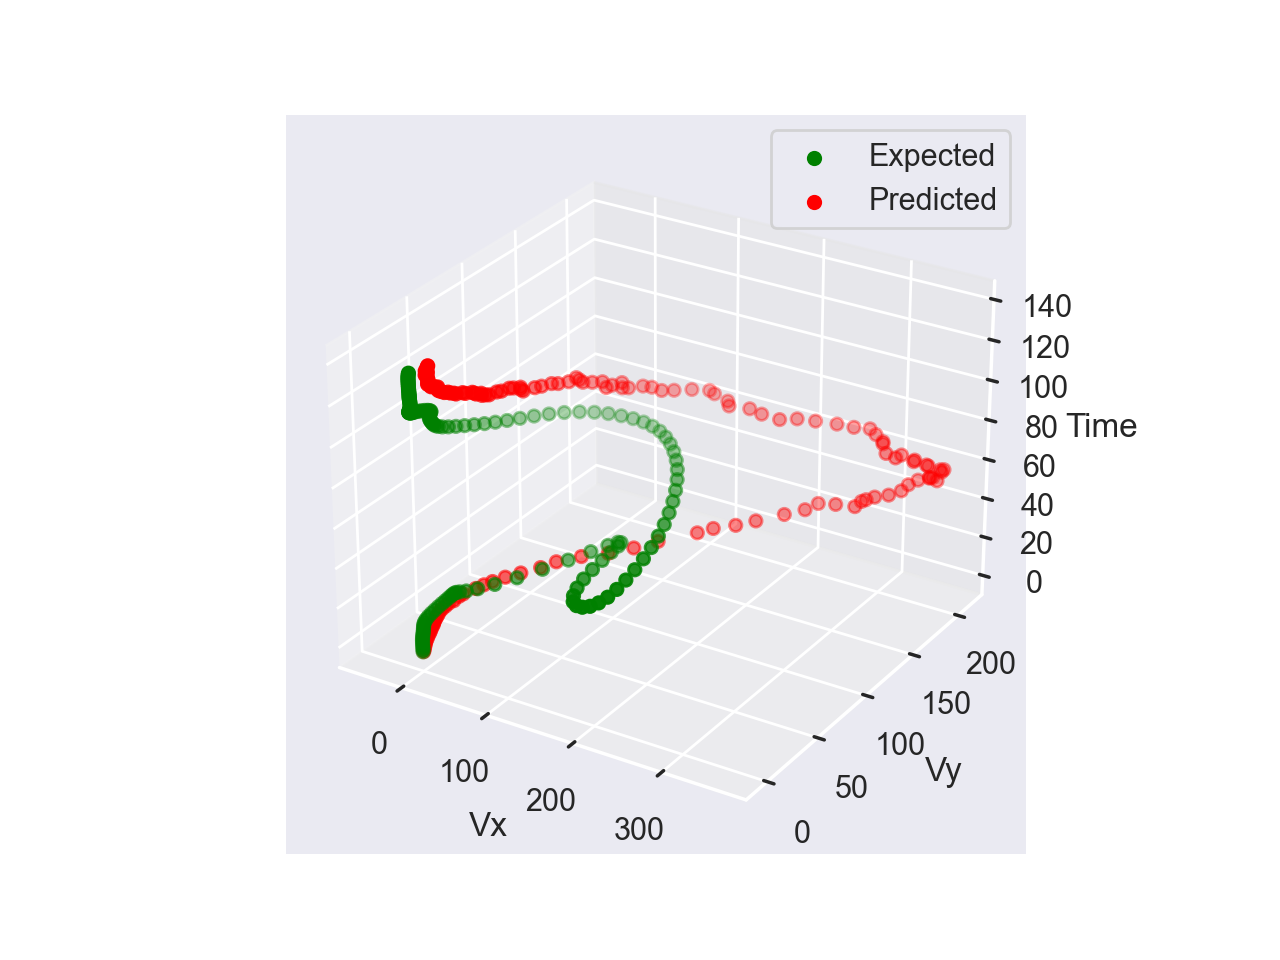

In [66]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

expected = train_output.data.numpy().mean(axis=0)
predicted = runner.model(train_input).data.numpy().mean(axis=0)

# Data for three-dimensional scattered points
zdata = np.arange(0, expected.shape[0])
xdata = expected[:, 0].T #+ 0.1 * np.random.randn(100)
ydata = expected[:, 1].T #+ 0.1 * np.random.randn(100)
ax.scatter(xdata, ydata, zdata, label='Expected', c='green')#, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
# zdata = np.linspace(0, train_output.shape[0])
xdata = predicted[:, 0].T #+ 0.1 * np.random.randn(100)
ydata = predicted[:, 1].T #+ 0.1 * np.random.randn(100)
ax.scatter(xdata, ydata, zdata, label='Predicted', c='red')# c=zdata, cmap='Reds');

ax.set_xlabel('Vx')
ax.set_ylabel('Vy')
ax.set_zlabel('Time')

plt.legend()



### Plot Spike Raster Plot

In [ ]:
def getEventData(inputData, threshold=0) :
    num_neurons = 8
    inp_np = inputData.data.numpy()
    inp_np = np.where(inp_np > threshold, 1, 0)

    a = np.nonzero(inp_np[0].T[:8])
    neuralDataObj = {}
    for n, time in zip(a[0], a[1]):
        if n  in neuralDataObj:
            neuralDataObj[n].append(time)
        else :
            neuralDataObj[n] = [time]
    neuralData = []


    for i in range(num_neurons) :
        if i in neuralDataObj :
            neuralData.append(neuralDataObj[i])
        else :
            neuralData.append([])

    return neuralData



In [ ]:
import matplotlib.pyplot as plt

import numpy as np

 

# Set the random seed for data generation

np.random.seed(2)
neuralData_input = getEventData(train_output)
neuralData_output = getEventData(runner.model(train_input), threshold = 0.2)
# Create rows of random data with 50 data points simulating rows of spike trains

# neuralData = train_input[0].T[:8] 
# neuralData = np.random.random([8, 50]) + 3

# Set different colors for each neuron

colorCodes = np.array([[0, 0, 0],
                        [1, 0, 0],
                        [0, 1, 0],
                      [0, 0, 1],
                        [1, 1, 0],
                        [1, 0, 1],
                        [0, 1, 1],
                        [1, 0, 1]])

# Set spike colors for each neuron
lineSize = [0.4, 0.3, 0.2, 0.8, 0.5, 0.6, 0.7, 0.9]                                  
# Draw a spike raster plot
fig, ax = plt.subplots(2, 1)


ax[0].eventplot(neuralData_input, color=colorCodes, linelengths = lineSize)     
ax[1].eventplot(neuralData_output, color=colorCodes, linelengths = lineSize)     

# Provide the title for the spike raster plot
ax[0].set_title('Spike raster plot')
# Give x axis label for the spike raster plot
ax[1].set_xlabel('Neuron')
# Give y axis label for the spike raster plot
ax[0].set_ylabel('Spike')
ax[1].set_ylabel('Spike')

# Display the spike raster plot
plt.show()

In [ ]:

def get_data(dataset_name, phase='test', bin_size=5):
    """Function that extracts and formats data for training model"""
    curr_path = os.getcwd()
    fpath = curr_path + '/datasets/000138/sub-Jenkins/'
    dataset = NWBDataset(fpath, 
        skip_fields=['cursor_pos', 'eye_pos', 'cursor_vel', 'eye_vel', 'hand_pos'])
    dataset.resample(1)
    train_split = ['train', 'val'] if phase == 'test' else 'train'
    eval_split = phase
    train_dict = make_train_input_tensors(dataset, dataset_name, train_split, save_file=False, include_forward_pred=True)
    eval_dict = make_eval_input_tensors(dataset, dataset_name, eval_split, save_file=False)
    training_input = np.concatenate([
        train_dict['train_spikes_heldin'],
        np.zeros(train_dict['train_spikes_heldin_forward'].shape),
    ], axis=1)
    training_output = np.concatenate([
        np.concatenate([
            train_dict['train_spikes_heldin'],
            train_dict['train_spikes_heldin_forward'],
        ], axis=1),
        np.concatenate([
            train_dict['train_spikes_heldout'],
            train_dict['train_spikes_heldout_forward'],
        ], axis=1),
    ], axis=2)
    eval_input = np.concatenate([
        eval_dict['eval_spikes_heldin'],
        np.zeros((
            eval_dict['eval_spikes_heldin'].shape[0],
            train_dict['train_spikes_heldin_forward'].shape[1],
            eval_dict['eval_spikes_heldin'].shape[2]
        )),
    ], axis=1)
    del dataset
    return training_input, training_output, eval_input

        
# Run parameters
dataset_name = 'mc_maze_large'
phase = 'val'
bin_size = 5

# Extract data
training_input, training_output, eval_input = get_data(dataset_name, phase, bin_size)
# smoothen the spike data using gaussian filter of 5ms standaed deviation
std_gaus = 5
training_input_filt = scipy.ndimage.gaussian_filter1d(training_input, std_gaus, axis=1)
training_output_filt = scipy.ndimage.gaussian_filter1d(np.float64(training_output), std_gaus, axis=1)
eval_input_filt = scipy.ndimage.gaussian_filter1d(eval_input, std_gaus, axis=1)

plt.figure()
plt.plot(training_input[1,:,0])

plt.figure()
plt.plot(training_input_filt[1,:,0])

# Downsample all of the train and eval data to 5ms step size
bin_size = 5
resamp_int = np.arange(0, training_input_filt.shape[1], bin_size)
training_input_filt = training_input_filt[:, resamp_int, :]
training_output_filt = training_output_filt[:, resamp_int, :]
eval_input_filt = eval_input_filt[:, resamp_int, :]
#print(training_input.shape)
#resamp_interval = np.arange(0, training_input.shape[1], 5)
#print(training_input[:, resamp_interval,:].shape)